# Mock Data Pipeline

`scippr` requires inputs in the form of catalogs $\{\ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{f}_{n}, \underline{\Phi}^{*}, \vec{\varphi}^{*}, \underline{\alpha}, \vec{\beta})]\}_{N}$ of interim log-posteriors expressed as `3D` arrays constituting probabilities over $t_{n}$, $z_{n}$, and $\mu_{n}$, enabling rapid computation of the log-posterior $\ln[p(\underline{\phi}, \vec{\Omega} | \{\underline{\ell}_{n}, \vec{f}_{n}\}_{N}, \underline{\alpha}, \vec{\beta})$ over the hyperparameters $\underline{\phi}$ and $\vec{\Omega}$ of scientific interest.  This notebook outlines a procedure for generating such a catalog.

Perhaps the defining feature of this pipeline is that it does not involve simulating supernova lightcurves or host galaxy photometry and instead simulating the interim posteriors directly.  There are several good reasons for this choice:

* The motivation for `scippr` is to develop a method for doing inference with accurate probability distributions over relevant supernova parameters, not to develop methods for obtaining those probability distributions.
* We avoid tying our inference method to a particular way of deriving interim posteriors from observed data.
* We avoid making assumptions about the details of the observed data, such as the photometric filters, intrinsic lightcurves, and observing conditions.

In [1]:
import daft
import astropy.cosmology as cosmology

import numpy as np
import bisect
import scipy.stats as sps
import scipy.interpolate as spi
import scipy.optimize as spo
import hickle

import os
paths = ['data', 'plots']
if not os.path.exists('data'):
    print('WARNING: You will need to put some data files in the `data` directory to have nontrivial mock data.')
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

import sys
log_epsilon = sys.float_info.min_exp
epsilon = sys.float_info.min

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)

# colors = 'rbgcymk'

`scippr` is based on a probabilistic graphical model, illustrated below.  The model has two types of observables, shown in shaded circles, supernova lightcurves $\underline{\ell}_{n}$ and host galaxy photometry $\vec{f}_{n}$.  The parameters, which are by definition not directly observable, are shown in empty circles.  The latent variables of supernova type $t_{n}$, redshift $z_{n}$, and distance modulus $\mu_{n}$ are parameters over which we will marginalize, without ever directly inferring them, and while all three of them influence $\underline{\ell}_{n}$, only $z_{n}$ affects $\vec{f}_{n}$ in this model.  In other words, _we currently assume no relationship between supernova type and host galaxy photometry, an assumption we may revisit in the future_.  The selection function parameters $\underline{\alpha}$ and $\vec{\beta}$ are known constants of the survey symbolized by dots that influence the possible lightcurves and host galaxy photometry that are included in the sample.  The box indicates that the latent variables and the observables are generated independently $N$ times for each supernova in the sample.  The hyperparameters we would like to estimate are the redshift-dependent supernova type proportions $\underline{\phi}$ that determine $t_{n}$ and $z_{n}$ and the cosmological parameters $\vec{\Omega}$ that relate $z_{n}$ to $\mu_{n}$, which are shared by all $N$ supernovae in the observed sample.  

To simulate a mock catalog for `scippr`, there are three main steps.

1. Choose true values for the hyperparameters, which we would like to recover from our inference, and the parameters, over which we intend to marginalize.
2. Create likelihoods based on a model for how they are derived from observations under the selection functions.
3. Make interim posteriors by assuming interim priors.

## Choosing true hyperparameters and parameters

### The redshift-dependent supernova type proportions

We assume that the true redshift-dependent type proportions are provided as parameters $\underline{\phi}'$ of continuous functions for a finite number of types across a restricted redshift range.  

*[The following cell is a placeholder for a realistic $\underline{\phi}'$.  It will soon be replaced with reading in a file containing this information.]*

In [2]:
types = ['Ia', 'Ibc', 'II']
colors = ['b', 'm', 'g']
n_types = len(types)
# making up the type fractions, will replace this with data soon!
frac_types = np.array([0.4, 0.1, 0.5])
assert np.isclose(np.sum(frac_types), 1.)

# these arbitrary limits are from the selection function
min_z = 0.2
max_z = 0.6

n_of_z_consts = {}
n_of_z_consts['Ia'] = (1.5, 0.5)
n_of_z_consts['Ibc'] = (1., 0.5)
n_of_z_consts['II'] = (0.5, 0.5)

true_n_of_z = []
for t in types:
    (mean, std) = n_of_z_consts[t]
    low, high = (min_z - mean) / std, (max_z - mean) / std
    print(low,high)
    true_n_of_z.append(sps.truncnorm(low, high, loc = mean, scale = std)) 

plot_res = 20
z_range = max_z - min_z
z_grid = np.linspace(min_z, max_z, num=plot_res + 1, endpoint=True) # making sure edges are wide enough
z_plot = (z_grid[1:] + z_grid[:-1]) / 2.
z_dif_plot = z_grid[1:] - z_grid[:-1]

-2.6 -1.8
-1.6 -0.8
-0.6 0.19999999999999996


Here we plot the true redshift-dependent type proportions after ensuring they are properly normalized.

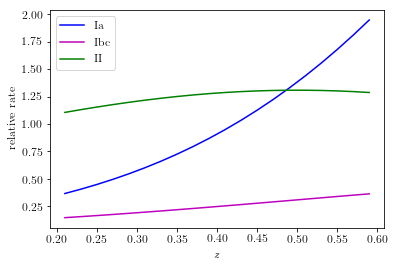

In [3]:
plot_true_n_of_z = np.zeros((n_types, plot_res))
for t in range(n_types):
    plot_true_n_of_z[t] = true_n_of_z[t].pdf(z_plot)
plot_true_n_of_z = frac_types[:, np.newaxis] * np.array(plot_true_n_of_z)# / z_range
plot_true_n_of_z /= np.sum(plot_true_n_of_z * z_dif_plot)
assert np.isclose(np.sum(plot_true_n_of_z * z_dif_plot), 1.)

for t in range(n_types):
    plt.plot(z_plot, plot_true_n_of_z[t], color=colors[t], label=types[t])
plt.xlabel(r'$z$')
plt.ylabel(r'relative rate')
plt.legend()
plt.savefig('plots/true_rates.png')

We sample pairs of type and redshift from these distributions by choosing a type based on the overall type proportions, then sampling its underlying redshift distribution.

In [4]:
def sample_discrete(fracs, n_of_z, N):
    found_types = [0, 0, 0]
    poster_indices = []
    out_info = []
    cdf = np.cumsum(fracs)
    for n in range(N):
        each = {}
        r = np.random.random()
        k = bisect.bisect(cdf, r)
        each['t'] = types[k]
        each['z'] = n_of_z[k].rvs()
        out_info.append(each)
    return out_info

n_sne = 400
true_id = range(n_sne)

true_params = sample_discrete(frac_types, true_n_of_z, n_sne)

true_zs = [true_param['z'] for true_param in true_params]
true_types = [true_param['t'] for true_param in true_params]
posters = []
posters.append(next(i for i,v in enumerate(true_types) if v == 'Ia'))
posters.append(next(i for i,v in enumerate(true_types) if v == 'Ibc'))
posters.append(next(i for i,v in enumerate(true_types) if v == 'II'))

In [5]:
print((1.29/1)**2)

1.6641000000000001


Here we plot a histogram of the true redshift values for the three types of supernovae, along with the redshift-dependent type functions from which they were drawn.

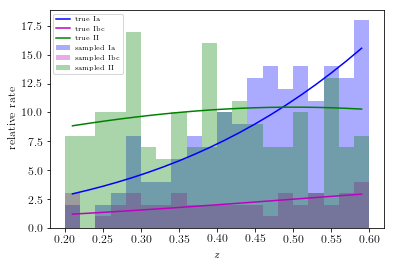

In [6]:
to_plot = [[d['z'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
hist_bins = np.linspace(min_z, max_z, plot_res + 1)
bin_difs = hist_bins[1:] - hist_bins[:-1]
for t in range(n_types):
    plt.plot(z_plot, plot_true_n_of_z[t] * n_sne * bin_difs, color=colors[t], label='true '+types[t])
    plt.hist(to_plot[t], bins=hist_bins, color=colors[t], alpha=1./3., label='sampled '+types[t], normed=False)
plt.xlabel(r'$z$')
plt.ylabel(r'relative rate')
plt.legend(fontsize='xx-small')
plt.savefig('plots/obs_rates.png')

### The true cosmological parameters

We define the true hyperparameter vector $\vec{\Omega}'$ as having two components, $w_{0}'$ and $w_{a}'$.  In a future revision, we may include additional cosmological parameters in this hyperparameter vector, but for now, they are held constant.  We choose the true values for the cosmological parameters to be those published by /Planck/ (2015, paper XIV, Figure 3).  [include citation]  

Since every supernova in our sample already has a true redshift $z_{n}'$, we can easily establish a true distance modulus $\mu_{n}'$ via the luminosity distance equation:

\begin{equation*}
\mu\ =\ 5\log\left[(1+z)\frac{1}{10\ pc}\int_{0}^{z}\frac{dz'}{\sqrt{\Omega_{M}(1+z)^{3}+\Omega_{k}(1+z)^{2}+\Omega_{\Lambda}}}\right]
\end{equation*}

[TO DO: Modify this for nontrivial $w_{0}$, $w_{a}$!  Luckily `asstropy` does this for us in code.]

In [7]:
# Planck 2015 results XIV. Dark energy and modified gravity - Figure 3
true_H0 = 67.9
true_Ode0 = 0.693
true_Om0 = 1. - true_Ode0
true_w0 = -1.09
true_wa = -0.20
true_hyperparams = np.array([true_w0, true_wa])
n_hyperparams = len(true_hyperparams)
#true_cosmo = cosmology.FlatLambdaCDM(H0=true_H0, Om0=true_Om0)
true_cosmo = cosmology.w0waCDM(true_H0, true_Om0, true_Ode0, w0=true_w0, wa=true_wa)

for n in range(n_sne):
    true_params[n]['mu'] = true_cosmo.distmod(true_params[n]['z']).value

We plot a traditional Hubble diagram of the supernovae in our sample.

*We must note that this is not a Hubble diagram like any other ever observed!  The distance moduli are of course not accessible for supernovae of types other than Ia.  However, non-Ia supernovae do still have a distance modulus, and do still follow the cosmological Hubble flow, so in simulated data, this is a perfectly reasonable quantity to visualize.*

Text(0.5,1,'$w_{0}=-1.09, w_{a}=-0.2$')

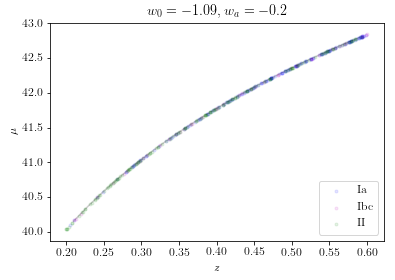

In [8]:
to_plot_x = [[d['z'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
to_plot_y = [[d['mu'] for d in true_params if d['t'] == types[t]] for t in range(n_types)]
for t in range(n_types):
    plt.scatter(to_plot_x[t], to_plot_y[t], color=colors[t], marker='.', label=types[t], alpha=0.1)
plt.plot(z_plot, [true_cosmo.distmod(z).value for z in z_plot], color='k', alpha=0.2)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.legend(loc='lower right')
plt.title(r'$w_{0}='+str(true_w0)+r', w_{a}='+str(true_wa)+r'$')
#plt.savefig('plots/true_hubble.png')

## Simulating Probabilities

`scippr` is intended to be used on interim posterior probabilities derived from a probabilistic lightcurve fitting procedure.  These will be provided as log-probabilities evaluated on a `3D` grid in type, redshift, and distance modulus space.  We choose to work with arrays of log-probabilities because they preserve numerical precision and enable slower products of arrays to be transformed into fast sums of arrays.  *This choice of parametrization for the input probabilities will be hard to change later on!*

Since we will be working in log-space, it is important to define functions that ensure that the elements of the log-probability arrays do not result in `NaN` values and do not throw errors in the functions used to take logs.  We do this by defining a very small positive number, many orders of magnitude less than the limit of floating point precision, as the minimum probability allowed in our universe, as welln as its log, a fairly large negative number. We will make use of functions to check that these conditions are satisfied.  This introduces some imprecision but cannot be avoided. 

In [9]:
def safe_log(arr, threshold=epsilon):
    arr[arr < threshold] = threshold
    return np.log(arr)

def reg_vals(arr, threshold=log_epsilon):
    arr[arr < threshold] = threshold
    return arr

We establish a binning in the space of $z$ and $\mu$ for the arrays of log-probabilities.  This is arbitrary and can easily be changed.  This binning is also used for the redshift-dependent type proportions because they are currently implemented in a piecewise constant parametrization, so the inference will be slower with more bins.

In [10]:
# this binning is arbitrary!
n_zs = 101
z_bins = np.linspace(min_z*(1.05), 0.95*max_z, num=n_zs, endpoint=True) 
#making sure the simulated redshifts always within the true!
z_difs = z_bins[1:] - z_bins[:-1]
z_dif = np.mean(z_difs)
z_mids = (z_bins[1:] + z_bins[:-1]) / 2.

mu_lims = (true_cosmo.distmod(min_z).value, true_cosmo.distmod(max_z).value)

# want this to be agnostic about true cosmology
n_mus = 101
(min_mu, max_mu) = mu_lims#mu_lims[0] - np.random.random(), mu_lims[1] + np.random.random()#min([s['mu'] for s in true_params]) - 0.5, max([s['mu'] for s in true_params]) + 0.5
mu_bins = np.linspace(min_mu, max_mu, num=n_mus, endpoint=True)
mu_difs = mu_bins[1:] - mu_bins[:-1]
mu_dif = np.mean(mu_difs)
mu_range = np.max(mu_bins) - np.min(mu_bins)
#print(mu_bins)
mu_mids = (mu_bins[1:] + mu_bins[:-1]) / 2.

z_mu_grid = np.array([[(z, mu) for mu in mu_mids] for z in z_mids])
cake_shape = np.shape(z_mu_grid)
unity = np.ones((n_sne, n_types, n_zs-1, n_mus-1))
pmin, pmax = log_epsilon, np.log(1./(min(z_difs) * min(mu_difs)))

We define additional functions to normalize probabilities so they integrate to unity over our $(t, z, \mu)$ parameter space.

In [11]:
unity_t = np.ones(n_types)
def normalize_t(arr, vb=False):
    norm_factor = np.sum(arr)
    arr /= norm_factor
    var = np.sum(arr)
    try:
        assert np.isclose(var, 1.)
        if vb: print(var)
    except AssertionError:
        print('normalization error '+str(var))
    return arr

unity_z = np.ones(n_zs-1)
def normalize_z(arr, vb=False):
    norm_factor = np.sum(arr * z_difs)
    arr /= norm_factor
    var = np.sum(arr * z_difs)
    try:
        assert np.isclose(var, 1.)
        if vb: print(var)
    except AssertionError: 
        print('normalization error '+str(var))
    return arr

unity_zt = np.ones((n_types, n_zs-1))
def normalize_zt(arr, vb=False):
    norm_factor = np.sum(arr * z_difs[np.newaxis, :])
    arr /= norm_factor
    var = np.sum(arr * z_difs[np.newaxis, :])
    try:
        assert np.isclose(var, 1.)
        if vb: print(var)
    except AssertionError: 
        print('normalization error '+str(var))
    return arr

unity_hubble = np.ones((n_zs-1, n_mus-1))
def normalize_hubble(arr, vb=False):
    norm_factor = np.sum(arr * z_difs[:, np.newaxis] * mu_difs[np.newaxis, :])
    arr /= norm_factor
    var = np.sum(arr * z_difs[:, np.newaxis] * mu_difs[np.newaxis, :])
    try: 
        assert np.isclose(var, 1.)
        if vb: print(var)
    except AssertionError: 
        print('normalization error '+str(var))
    return arr

unity_one = np.ones((n_types, n_zs-1, n_mus-1))
def normalize_one(arr, vb=False):
    norm_factor = np.sum(arr * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
    arr /= norm_factor
    var = np.sum(arr * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
    try: 
        assert np.isclose(var, 1.)
        if vb: print(var)
    except AssertionError: 
        print('normalization error '+str(var))
    return arr

unity_all = np.ones((n_sne, n_types, n_zs-1, n_mus-1))
def normalize_all(arr, vb=False):
    n_objs = len(arr)
    norm_factor = np.sum(np.sum(np.sum(arr * z_difs[np.newaxis, np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, np.newaxis, :], axis=3), axis=2), axis=1)
    arr /= norm_factor[:, np.newaxis, np.newaxis, np.newaxis]
    var = np.sum(np.sum(np.sum(arr * z_difs[np.newaxis, np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, np.newaxis, :], axis=3), axis=2), axis=1)
    try:
        assert np.all(np.isclose(var, np.ones(n_objs)))
        if vb: print(var)
    except AssertionError: 
        print('normalization error '+str(var))
    return arr

We will construct the three-dimensional log probabilities produced by a probabilistic lightcurve fitter separately from the one-dimensional log-probabilities produced by a probabilistic redshift fitter and combine them at the end as follows:

\begin{equation*}
\ln[p(t_{i}, z_{i}, \mu_{i} | \underline{\ell}_{i}, \vec{f}_{i}, \underline{\alpha}, \vec{\beta}, \underline{\Phi}^{*}, \vec{\varphi}^{*})]\ =\ \ln[p(t_{i}, z_{i}, \mu_{i} | \underline{\ell}_{i}, \underline{\alpha}, \underline{\Phi}^{*})]\ +\ \ln[p(t_{i}, z_{i}, \mu_{i} | \vec{f}_{i}, \vec{\beta}, \vec{\varphi}^{*})]
\end{equation*}

### Supernova lightcurve probability distributions

\begin{equation*}
\ln[p(t_{i}, z_{i}, \mu_{i} | \underline{\ell}_{i}, \underline{\alpha}, \underline{\Phi}^{*}]\ =\ \ln[p(t_{i}, z_{i}, \mu_{i} | \underline{\ell}_{i})]\ +\ \ln[p(t_{i}, z_{i}, \mu_{i} | \underline{\alpha})]\ +\ \ln[p(t_{i}, z_{i}, \mu_{i} | \underline{\Phi}^{*})]
\end{equation*}

**Supernova lightcurve log-posteriors**

$\ln[p(t, z, \mu | \underline{\ell}_{i})]$

Based on how existing lightcurve fitters work, a lightcurve is generally assigned a class before its redshift and distance modulus are estimated because the fitting function will differ based on the assigned class.  Thus, we may assume that the supernova lightcurve posterior is separable as follows:

\begin{equation*}
\ln[p(t, z, \mu | \underline{\ell}_{i})] = \ln[p(t | \underline{\ell}_{i})] + \ln[p(z, \mu | t, \underline{\ell}_{i})]
\end{equation*}

*Lightcurve classification*

The confusion matrix quantifies the probabilities that an item is truly of a certain class given the fact that it has been classified as a different class.  (A more in-depth description of the confusion matrix can be found [here](https://github.com/rbiswas4/SNeLightcurveQualityMetric/blob/master/classification_metric.tex).)  We will use the $p(t'_{i} | t)$ elements of the confusion matrix to make $p(t | t'_{i})$ (via Bayes' rule), a proxy for $p(t | \underline{\ell}_{i})$ as follows:

\begin{equation*}
p(t | t'_{i})\ =\ p(t'_{i} | t)\ \frac{p(t)}{p(t'_{i})}
\end{equation*}

We recall that the sum across rows of the confusion matrix is $p(t')$ and the sum down columns is $p(t)$.

The confusion matrix is specific to each classification method, so we will have to choose one to simulate a realistic mock dataset.  For now, we proceed assuming a fairly trivial confusion matrix giving a 50% chance of correct classification for each type and equal probabilities for all misclassifications.  TO DO: read this in from a file created by a realistic classifier.

In [12]:
# will need to take this from data of some kind, arbitrary for now
#conf_matrix = (0.25 + 0.25 * np.eye(3)) * frac_types[:, np.newaxis]
#making a worse confusion matrix
conf_matrix = (0.25 + 0.25 * np.eye(3)) * frac_types[:, np.newaxis]
true_rates = np.sum(conf_matrix, axis=1)
obs_rates = np.sum(conf_matrix, axis=0)
# print(conf_matrix, frac_types, true_rates, obs_rates)
conf_matrix /= true_rates[:, np.newaxis]
# print(conf_matrix)

assert np.all(np.isclose(true_rates, frac_types))

ln_conf_matrix = safe_log(conf_matrix)

*$\chi^{2}$ lightcurve parameter fitting*

In order to produce $p(z, \mu | t, \underline{\ell}_{i})$, we will again introduce the idea of using the true type $t_{i}'$ as a proxy for the lightcurve $\underline{\ell}_{i}$ and a classified type $t$ for the variable type $t$ that appears in the probability expressions.  If we do this, the quantity we want is really $p(z, \mu | t, t'_{i})$.  We can obtain this knowing how lightcurve fitters, in general, estimate redshifts $z$ and distance moduli $\mu$ under all possible combinations of $t_{i}'$ and $t$.  We will construct functions that aim to simulate the signatures of misclassification in the Hubble diagram [like the one here](http://iopscience.iop.org/article/10.1088/0004-637X/752/2/79/meta;jsessionid=620BA2E6C84CD7FD5AC88DDB72680B0C.ip-10-40-2-120#apj429245f3).  Currently, we use placeholder functions that will be replaced later on as information about the consequences of fitting with the wrong function becomes available.  The table below summarizes the fitting function for each true type given a classification of type $Ia$.  All other classified types are assumed to give a distribution that is uniform in $\mu$ and Gaussian in $z$ according to the same prescription used for the photo-$z$ PDFs.

| True Type $t_{i}'$ | Functional Form of posterior $p(z, \mu | t, t'_{i})$ for $t=Ia$|
| :----------------: | :------------------------------------------------------------: |
| Ia | $\vec{\mathcal{N}}((z_{i}'', \mu_{i}''), \underline{\Sigma}_{t_{i}'=Ia})$ where $\underline{\Sigma}_{t_{i}'=Ia}=(\sigma^{2}_{z_{i},Ia}, \sigma^{2}_{\mu_{i},Ia})\times\underline{I}$ and $(z_{i}'', \mu_{i}'')\sim\vec{\mathcal{N}}((z_{i}', \mu_{i}'), \underline{\Sigma}_{t_{i}'=Ia})$ |
| Ibc | $\vec{\mathcal{N}}((z_{i}'', \mu_{i}''), \underline{\Sigma}_{t_{i}'=Ibc})$ where $\underline{\Sigma}_{t_{i}'=Ibc}=(\sigma^{2}_{z_{i},Ibc}, \sigma^{2}_{\mu_{i},Ibc})\times\underline{I}$ and $(z_{i}'', \mu_{i}'')\sim\vec{\mathcal{N}}((z_{i}', \mu_{i}' - C_{Ibc}), \underline{\Sigma}_{t_{i}'=Ibc})$ for survey-wide constant $C_{Ibc}$ |
| II | $\vec{\mathcal{N}}((z_{i}'', \mu_{i}''), \underline{\Sigma}_{t_{i}'=II})$ where $\underline{\Sigma}_{t_{i}'=II}=(\sigma^{2}_{z_{i},II}, \sigma^{2}_{\mu_{i},II})\times\underline{I}$ and $(z_{i}'', \mu_{i}'')\sim\vec{\mathcal{N}}((z_{i}', C_{II}), \underline{\Sigma}_{t_{i}'=II})$ for survey-wide constant $C_{II}$ |

In a future revision, the values of $\sigma^{2}_{z_{i},t}$ and $\sigma^{2}_{\mu_{i},t}$ for each type $t$ will be replaced by random variables themselves representing the intrinsic variation among lightcurves, but for now they are constant for all $i$.

In [13]:
# must set nuisance parameters inherent in process of producing interim posteriors from lightcurves
#Ia_Ia_var = np.array([0.001, 0.02]) ** 2 #original
Ia_Ia_var = np.array([0.001, 0.04]) ** 2
Ibc_Ia_delta = 0.25
Ibc_Ia_var = np.array([0.001, 0.01]) ** 2
II_Ia_delta = np.mean(mu_mids)
II_Ia_var = np.array([0.001, 0.04]) ** 2

# cake_shape = np.zeros((n_zs-1, n_mus-1))

# definitely needs more work on what (z, mu) distributions are expected when lightcurves are fit with wrong templates
# just made it flat for now

def fit_Ia(z, mu, vb=False):
#     cake = unity_hubble#np.zeros((n_types, n_zs-1, n_mus-1))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, mu]), cov = Ia_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = Ia_Ia_var * np.eye(2))
    cake = normalize_hubble(cake_Ia.pdf(z_mu_grid.reshape(((n_zs-1)*(n_mus-1), 2))).reshape((n_zs-1, n_mus-1)), vb=vb)
    return cake
    
def fit_Ibc(z, mu, vb=False):
#     cake = np.zeros((n_types, n_zs-1, n_mus-1))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, mu - Ibc_Ia_delta]), cov = Ibc_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = Ibc_Ia_var * np.eye(2))
    cake = normalize_hubble(cake_Ia.pdf(z_mu_grid.reshape(((n_zs-1)*(n_mus-1), 2))).reshape((n_zs-1, n_mus-1)), vb=vb)
    return cake
    
def fit_II(z, mu, vb=False):
#     cake = np.zeros((n_types, n_zs-1, n_mus-1))
    cake_Ia = sps.multivariate_normal(mean = np.array([z, II_Ia_delta]), cov = II_Ia_var * np.eye(2))
    [z_samp, mu_samp] = cake_Ia.rvs()
    cake_Ia = sps.multivariate_normal(mean = np.array([z_samp, mu_samp]), cov = II_Ia_var * np.eye(2))
    cake = normalize_hubble(cake_Ia.pdf(z_mu_grid.reshape(((n_zs-1)*(n_mus-1), 2))).reshape((n_zs-1, n_mus-1)), vb=vb)
    return cake

In [14]:
z_sigma = 0.03

def fit_any(true_vals, vb=False):
#     print(unity_one)
    cake = np.zeros((n_types, n_zs-1, n_mus-1))#unity_one.copy()
#     print(unity_one)
    if true_vals['t'] == 'Ia':
        cake[0] = fit_Ia(true_vals['z'], true_vals['mu'], vb=vb)
        ln_conf = ln_conf_matrix[0]
    if true_vals['t'] == 'Ibc':
        cake[0] = fit_Ibc(true_vals['z'], true_vals['mu'], vb=vb)
        ln_conf = ln_conf_matrix[1]
    if true_vals['t'] == 'II':
        cake[0] = fit_II(true_vals['z'], true_vals['mu'], vb=vb)
        ln_conf = ln_conf_matrix[2]
    if vb: print(np.exp(ln_conf))
    dist = sps.norm(loc = true_vals['z'], scale = z_sigma)
    z_means = dist.rvs(2)
    layer_Ibc = sps.norm(loc = z_means[0], scale = z_sigma).pdf(z_mids)
#     print(layer_Ibc)
    layer_II = sps.norm(loc = z_means[1], scale = z_sigma).pdf(z_mids)
#     print(layer_II)
    cake[1] = normalize_hubble(unity_hubble * layer_Ibc[:, np.newaxis], vb=vb)
    cake[2] = normalize_hubble(unity_hubble * layer_II[:, np.newaxis], vb=vb)
#     cake = normalize_one(cake)
    if not np.all(cake>=0.):
        print(true_vals)
        assert False
    cake = reg_vals(safe_log(cake) + ln_conf[:, np.newaxis, np.newaxis])
#     cake = safe_log(normalize_one(np.exp(cake)))
    if vb: print(np.sum(np.sum(np.exp(cake) * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :], axis=2), axis=1))
    return cake

def fit_all(catalog, vb=False):
    dessert = []
    i=0
    for true_vals in catalog:
        if vb: print(i)
        thing = fit_any(true_vals, vb=vb)
        try:
            dessert.append(thing)
        except AssertionError:
            print('error '+str(thing))
        i += 1
    return np.array(dessert)

sheet_cake = fit_all(true_params, vb=False)
sheet_cake = reg_vals(safe_log(normalize_all(np.exp(sheet_cake), vb=False)))

# assert(not np.any(np.isnan(hub_only_sheet_cake)))
# sheet_cake = hub_only_sheet_cake + ln_conf_matrix[np.newaxis, :, np.newaxis, np.newaxis]
# exp_sheet_cake = np.exp(sheet_cake)
# sheet_cake_norm = np.sum(np.sum(np.sum(exp_sheet_cake * z_difs[np.newaxis, np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, np.newaxis, :], axis=3), axis=2), axis=1)
# exp_sheet_cake /= sheet_cake_norm[:, np.newaxis, np.newaxis, np.newaxis]
# # print(np.sum(exp_sheet_cake * z_difs[np.newaxis, np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, np.newaxis, :]))
# assert np.isclose(np.sum(exp_sheet_cake * z_difs[np.newaxis, np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, np.newaxis, :]), n_sne)
# sheet_cake = safe_log(exp_sheet_cake)

We plot a handful of these posteriors.  Each row is the log-posterior for a different supernova in the catalog.  The columns represent the log-posterior in the space of $z$ and $\mu$ (Hubble diagram-space) for that supernova if it were classified as type $Ia$, type $Ibc$ and type $II$.  The true $z$ and $\mu$ for each are also plotted.  The title of each panel gives the true type for each supernova.  We can see the effect on the posterior for $z$ and $\mu$ based on each combination of true and classified type.

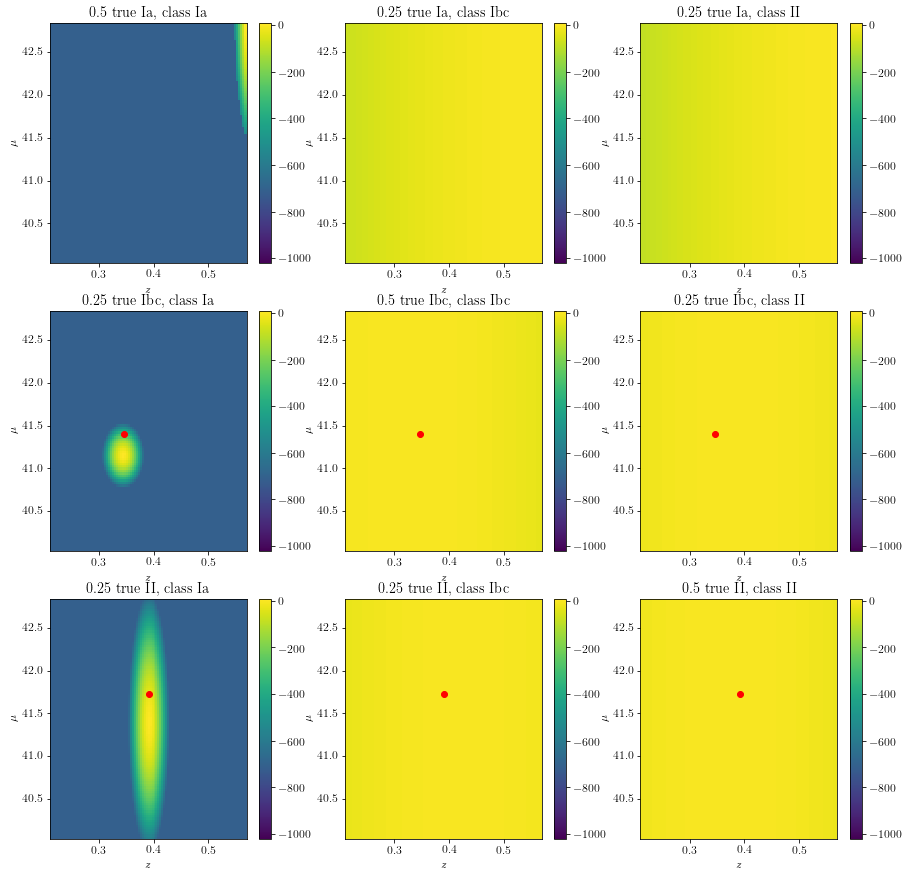

In [15]:
# exp_sheet_cake = np.exp(sheet_cake)
# pmin, pmax = 0., np.max(exp_sheet_cake)


# happily, these look like what we see in contaminated hubble diagrams!
fig = plt.subplots(figsize=(n_types*5, n_types*5))
p = 0
for s in posters:#range(n_sne)[:len(colors)]:
    type_dist = np.sum(np.sum(np.exp(sheet_cake[s]) * mu_difs[np.newaxis, np.newaxis, :] * z_difs[np.newaxis, :, np.newaxis], axis=2), axis=1)
    for t in range(n_types):
        p += 1
        plt.subplot(n_types, n_types, p)
#         print(t, np.sum(np.exp(sheet_cake[s][t]) * z_difs[:, np.newaxis] * mu_difs[np.newaxis, :]))
#         print(np.min(sheet_cake[s][t]), np.max(sheet_cake[s][t]), np.sum(sheet_cake[s][t]))
        plt.pcolormesh(z_bins, mu_bins, sheet_cake[s][t].T, cmap='viridis', vmin=pmin, vmax=pmax)
        plt.colorbar()#orientation='horizontal')
        plt.scatter(true_params[s]['z'], true_params[s]['mu'], color='r')
        plt.title(str(type_dist[t])+' true '+true_params[s]['t']+', class '+types[t])
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])

plt.show()
plt.savefig('plots/snlc_posteriors.png')

**Supernova lightcurve selection function**

$\ln[p(t, z, \mu | \underline{\alpha})]$

We want to go directly to $p(t, z, \mu | \underline{\alpha})$ knowing only $p(\underline{\ell} | \vec{\alpha})$ and $p(t, z, \mu | \underline{\ell})$. We note that in the empirical approach, because $\mu$ is determined by $z$ in the probailistic graphical model, we can say $p(t, z, \mu | \underline{\alpha}) = p(t, z | \underline{\alpha}) = \int\ p(t, z | \underline{\ell})\ p(\underline{\ell} | \underline{\alpha})\ d\underline{\ell}$.

In [16]:
# We emulate this using data from a realistic supernova simulation.
# We want the number of supernovae as a function of redshift and SN type.
# (The cadence studies with SNANA should have this.)
# Using a realistic set of selection cuts, we want to calculate the recovered fraction
# of SN as a function of SN type and redshift under a given survey strategy
# relative to the "best possible" survey strategy.
if not (os.path.exists('data/ratios_wfd.txt') and os.path.exists('data/ratios_ddf.txt')):
    print('WARNING: No SN LC selection function data found in `data` directory, using flat SN LC selection function instead.')
    sn_sel_fun_in = unity_zt.copy() # RH changed this
    sn_sel_fun_in=sn_sel_fun_in[0:len(z_bins)]
    #print(sn_sel_fun_in,len(z_bins))
else:
    with open('data/ratios_wfd.txt', 'r') as wfd_file:
    #     wfd_file.next()
        tuples = (line.split(None) for line in wfd_file)
        wfddata = [[pair[k] for k in range(0,len(pair))] for pair in tuples]
    n_sel_fun_zs = 6
    zs_eval = np.array([float(wfddata[i][0]) for i in range(1, n_sel_fun_zs)])
    wfd_data = np.array([np.array([int(wfddata[i][2 * j]) for j in range(1, (len(wfddata[i]))/2+1)]) for i in range(1, n_sel_fun_zs)])
    wfd_data[np.isnan(wfd_data)] = 0.
    # print(wfd_data)
    with open('data/ratios_ddf.txt', 'r') as ddf_file:
    #     ddf_file.next()
        tuples = (line.split(None) for line in ddf_file)
        ddfdata = [[pair[k] for k in range(0,len(pair))] for pair in tuples]
    ddf_data = np.array([np.array([float(ddfdata[i][2 * j]) for j in range(1, (len(ddfdata[i]))/2+1)]) for i in range(1, n_sel_fun_zs)])
    # print(ddf_data)
    # these are the recovery rates
    sn_sel_fun_in = np.transpose(wfd_data / ddf_data)
    # sn_sel_fun = sn_sel_fun.T
    # print(sn_sel_fun)
# It's actually a big problem for the selection function to go to 0 or exceed 1.
# Note: these need to be normalized by survey volume so are not valid at this time!

1.0


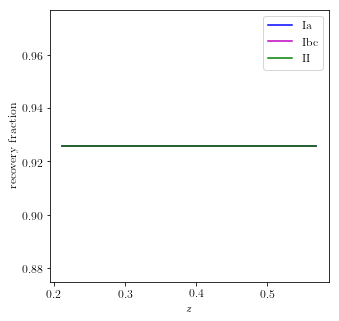

In [17]:
#need to fix this to interpolate selection function to grid but broken for now
# #purity = # real classified as real / all classified as real
# #want real classified as real / all true real
# #for now using purity as what we want
# #should use really low purity for testing to check that it's doing something!
# #need this to be # types * # z bins in shape
sn_sel_fun_out = np.ones((n_types, n_zs-1))
#print(np.shape(sn_sel_fun_out), np.shape(sn_sel_fun_in), zs_eval)
#for t in range(n_types):
#    interpolator = spi.interp1d(zs_eval, sn_sel_fun_in[t])
#    interpolated = interpolator(z_mids)
#    sn_sel_fun_out[t] = interpolated
# uniform selection in type
# sn_sel_fun = np.vstack((interpolated, interpolated, interpolated))#((interpolated, 1.*interpolated/3., 2.*interpolated/3.))
#should divide this by DDF, for now say it's perfect
# sn_sel_fun /= np.ones((n_types, n_zs))
sn_sel_fun_out = np.ones((n_types, n_zs-1))
sn_sel_fun_z = normalize_zt(sn_sel_fun_out, vb=True)

plt.figure(figsize=(5, 5))
for t in range(n_types):
    plt.plot(z_mids, sn_sel_fun_z[t], label=types[t], color=colors[t])
plt.xlabel(r'$z$')
plt.ylabel('recovery fraction')
plt.legend(loc='upper right')
plt.savefig('plots/lc_sel_func.png')

1.0


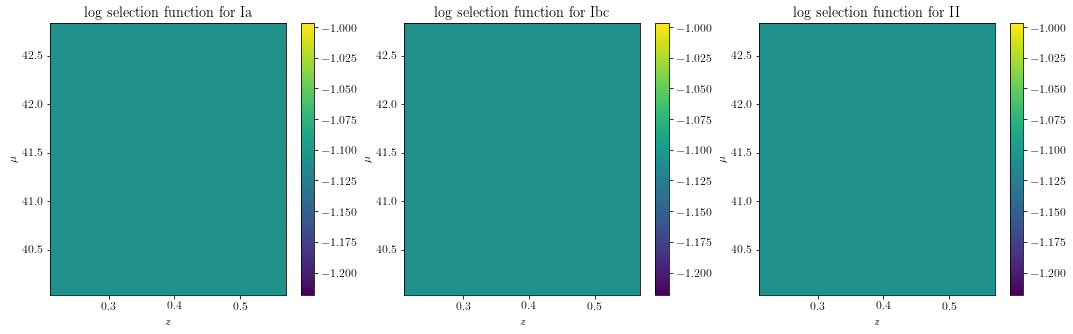

In [18]:
#will need this for inference, should write to file and skeleton should read it in
sn_sel_fun = normalize_one(sn_sel_fun_z[:, :, np.newaxis] * unity_one, vb=True)
# sn_sel_fun_norm = np.sum(sn_sel_fun * z_difs[np.newaxis, :])
# sn_sel_fun /= sn_sel_fun_norm
# assert np.isclose(np.sum(sn_sel_fun * z_difs[np.newaxis, :]), 1.)
ln_sn_selection_function = safe_log(sn_sel_fun)

#ignore this because these are not probabilities!
# sn_selection_function = np.ones((n_types, n_zs-1, n_mus-1))
# sn_selection_function /= np.sum(sn_selection_function * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
# ln_sn_selection_function = safe_log(sn_selection_function)

selfunmin, selfunmax = np.min(ln_sn_selection_function), np.max(ln_sn_selection_function)
fig = plt.figure(figsize=(n_types*6, 5))
p = 0
for t in range(n_types):
    p += 1
    plt.subplot(1, n_types, p)
    plt.pcolormesh(z_bins, mu_bins, ln_sn_selection_function[t].T, cmap='viridis', vmin=selfunmin, vmax=selfunmax)
    plt.colorbar()
    plt.title('log selection function for '+types[t])
    plt.xlabel(r'$z$')
    plt.ylabel(r'$\mu$')
#     plt.legend(loc='upper left')
    plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
plt.savefig('plots/lc_sel_fun_full.png')

**Supernova lightcurve interim prior**

$\ln[p(t, z, \mu | \underline{\Phi}^{*})$

To transform our posteriors into interim posteriors that accurately represent what we expect a real data analysis pipeline to produce, we must choose interim priors.  The interim prior represents the $p(t, z, \mu)$ that is used in the estimation of log-posterior probabilities -- our assumptions about $p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n})$ are parametrized by the interim prior parameters comprising $\underline{\Phi}^{*}$, so the closest we can get to the desired posteriors is the interim posteriors $\ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \underline{\Phi}^{*})].

This section is about making the interim prior $\ln[p(t, z, \mu | \underline{\xi})]$.

In [19]:
# could replace this with non-flat
# SN interim prior in z-dependent type proportion space
sn_interim_nz = np.ones((n_types, n_zs-1))#this is flat, replace this with nontrivial interim prior on types and redshifts
# sn_interim_nz /= np.sum(sn_interim_nz * z_difs[np.newaxis, :])
# assert np.isclose(np.sum(sn_interim_nz * z_difs[np.newaxis, :]), 1.)
sn_interim_nz = normalize_zt(sn_interim_nz)

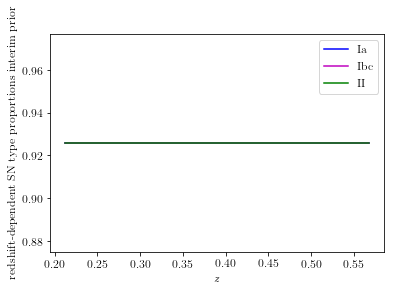

In [20]:
for t in range(n_types):
    plt.plot(z_mids, sn_interim_nz[t], label=types[t], color=colors[t])
plt.xlabel(r'$z$')
plt.ylabel('redshift-dependent SN type proportions interim prior')
plt.legend(loc='upper right')
plt.savefig('plots/lc_int_pr.png')

In [21]:
sn_interim_nz = normalize_one(unity_one * sn_interim_nz[:, :, np.newaxis])
ln_sn_interim_nz = safe_log(sn_interim_nz)

In [22]:
# flat prior on redshift-dependent SNe proportions, replace with SDSS n(z)
# interim_n_of_z = np.ones((n_types, n_zs-1))
# interim_n_of_z /= np.sum(interim_n_of_z * z_difs[np.newaxis, :])
# assert np.isclose(np.sum(interim_n_of_z * z_difs[np.newaxis, :]), 1.)
# interim_ln_n_of_z = safe_log(interim_n_of_z)

# read these off Planck plots
interim_H0 = true_H0#70.0
delta_H0 = 2.2# * 10.
interim_Om0 = true_Om0#1. - 0.721
delta_Om0 = 0.025# * 10.
interim_Ode0 = true_Ode0
delta_Ode0 = 0.025 * 10.
interim_w0 = -1.0#true_w0
delta_w0 = 0.05#0.2# * 10.
interim_wa = 0.0#true_wa
delta_wa = 0.05#1.5# * 10.
interim_cosmo_hyperparams = np.array([interim_w0, interim_wa])
interim_cosmo_hyperparam_sigmas = np.array([delta_w0, delta_wa])
interim_cosmo_hyperparam_vars = (interim_cosmo_hyperparam_sigmas) * np.eye(n_hyperparams)
interim_dist = sps.multivariate_normal(mean = interim_cosmo_hyperparams, cov = interim_cosmo_hyperparam_vars)
interim_cosmo = cosmology.w0waCDM(interim_H0, interim_Om0, interim_Ode0, w0=interim_w0, wa=interim_wa)
def inverter(z, mu):
    #note: this inverter is slow! perhaps we could speed it up with interpolation over predefined grids?
    def cosmo_helper(hyperparams):
        return np.array([abs(cosmology.w0waCDM(interim_H0, interim_Om0, interim_Ode0, w0=hyperparams[0], wa=hyperparams[1]).distmod(z).value - mu)])
    solved_cosmo = spo.minimize(cosmo_helper, interim_cosmo_hyperparams, method="Nelder-Mead", options={"maxfev": 1e5, "maxiter":1e5})
    prob = interim_dist.pdf(solved_cosmo.x)
    return prob#max(prob, sys.float_info.epsilon)

# interim_H0 = true_H0#70.0
# delta_H0 = 2.2# * 10.
# interim_Om0 = true_Om0#1. - 0.721
# delta_Om0 = 0.025#*10
# interim_cosmo_hyperparams = np.array([interim_H0, interim_Om0])
# interim_cosmo_hyperparam_sigmas = np.array([delta_H0, delta_Om0])
# interim_cosmo_hyperparam_vars =  interim_cosmo_hyperparam_sigmas * np.eye(n_hyperparams)
# interim_dist = sps.multivariate_normal(mean = interim_cosmo_hyperparams, cov = interim_cosmo_hyperparam_vars)
# interim_cosmo = cosmology.FlatLambdaCDM(H0=interim_H0, Om0=interim_Om0)
# def inverter(z, mu):
#     #note: this inverter is slow! perhaps we could speed it up with interpolation over predefined grids?
#     def cosmo_helper(hyperparams):
#         return np.array([abs(cosmology.FlatLambdaCDM(H0=hyperparams[0], Om0=hyperparams[1]).distmod(z).value - mu)])
#     solved_cosmo = spo.minimize(cosmo_helper, interim_cosmo_hyperparams, method="Nelder-Mead", options={"maxfev": 1e5, "maxiter":1e5})
#     prob = interim_dist.pdf(solved_cosmo.x)
#     assert(not np.isnan(prob))
#     return prob#max(prob, sys.float_info.epsilon)

# may have to change this if nontrivial covariances between hyperparameters=
#interim_hyperparams['theta'] = np.array([interim_cosmo_hyperparams, interim_cosmo_hyperparam_sigmas])
#interim_hyperparams['phi'] = interim_ln_n_of_z

In [23]:
# SN interim prior in Hubble diagram space
sn_interim_hubble = np.zeros((n_zs-1, n_mus-1))
for z in range(n_zs-1):
    for mu in range(n_mus-1):
        prob = inverter(z_mids[z], mu_mids[mu])
        sn_interim_hubble[z][mu] = prob
# print(np.sum(sn_interim_hubble * z_difs[:, np.newaxis] * mu_difs[np.newaxis, :]))
sn_interim_hubble = normalize_hubble(sn_interim_hubble)
ln_sn_interim_hubble = safe_log(sn_interim_hubble)


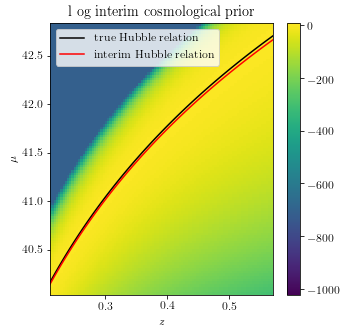

In [24]:
# fig = plt.figure(figsize=(5, 5))
# plt.pcolormesh(z_bins, mu_bins, ln_sn_interim_hubble.T, cmap='viridis')
# plt.plot(z_bins, [true_cosmo.distmod(z).value for z in z_bins], color='k', label='true Hubble relation')
# plt.plot(z_bins, [interim_cosmo.distmod(z).value for z in z_bins], color='r', label='interim Hubble relation')
# plt.colorbar()
# plt.title('log interim cosmological prior')
# plt.xlabel(r'$z$')
# plt.ylabel(r'$\mu$')
# plt.legend(loc='upper left')
# plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
# plt.savefig('plots/lc_interim_w0waCDM.png')

fig = plt.figure(figsize=(5, 5))
plt.pcolormesh(z_bins, mu_bins, ln_sn_interim_hubble.T, cmap='viridis', vmin=pmin, vmax=pmax)
plt.plot(z_bins, [true_cosmo.distmod(z).value for z in z_bins], color='k', label='true Hubble relation')
plt.plot(z_bins, [interim_cosmo.distmod(z).value for z in z_bins], color='r', label='interim Hubble relation')
plt.colorbar()
plt.title('l og interim cosmological prior')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.legend(loc='upper left')
plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
plt.savefig('plots/lc_interim_FlatLambdaCDM.png')

In [25]:
sn_interim_hubble = normalize_one(unity_one * sn_interim_hubble[np.newaxis, :, :])
ln_sn_interim_hubble = safe_log(sn_interim_hubble)

In [26]:
ln_sn_interim = reg_vals(ln_sn_interim_nz + ln_sn_interim_hubble)
sn_interim = np.exp(ln_sn_interim)
ln_sn_interim = safe_log(normalize_one(sn_interim))

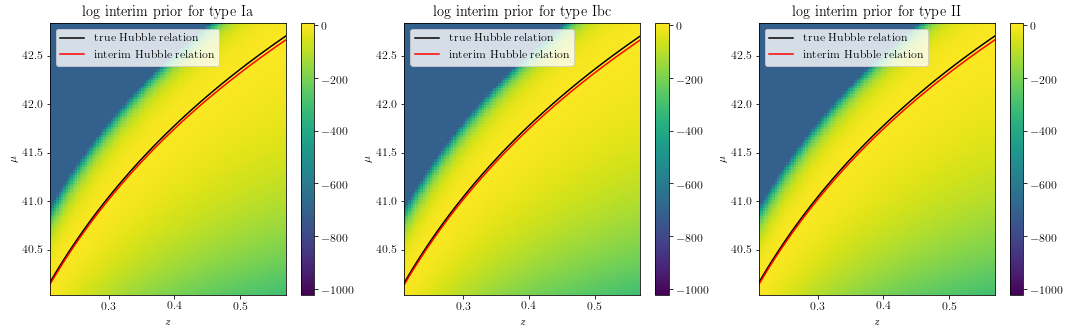

In [27]:
fig = plt.figure(figsize=(n_types*6, 5))
p = 0
for t in range(n_types):
    p += 1
    plt.subplot(1, n_types, p)
    plt.pcolormesh(z_bins, mu_bins, ln_sn_interim[t].T, cmap='viridis', vmin=pmin, vmax=pmax)
    plt.plot(z_bins, [true_cosmo.distmod(z).value for z in z_bins], color='k', label='true Hubble relation')
    plt.plot(z_bins, [interim_cosmo.distmod(z).value for z in z_bins], color='r', label='interim Hubble relation')
    plt.colorbar()
    plt.title('log interim prior for type '+types[t])
    plt.xlabel(r'$z$')
    plt.ylabel(r'$\mu$')
    plt.legend(loc='upper left')
    plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
plt.savefig('plots/lc_interim_combo.png')

# plt.pcolormesh(z_bins, mu_bins, ln_sn_interim[0].T, cmap='viridis')#, vmin = 0., vmax = 3.)
# plt.plot(z_bins, [true_cosmo.distmod(z).value for z in z_bins], color='k', label='true Hubble relation')
# plt.title('interim prior distribution')
# plt.xlabel(r'$z$')
# plt.ylabel(r'$\mu$')
# plt.legend(loc='lower right', fontsize='small')
# plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
# plt.colorbar()
# plt.savefig('plots/sn_interim_prior.png')

### Host galaxy photometry probability distributions

\begin{equation*}
\ln[p(t_{i}, z_{i}, \mu_{i} | \vec{f}_{i}, \vec{\beta}, \vec{\varphi}^{*})]\ =\ \ln[p(t_{i}, z_{i}, \mu_{i} | \vec{f}_{i})]\ +\ \ln[p(t_{i}, z_{i}, \mu_{i} | \vec{\beta})]\ +\ \ln[p(t_{i}, z_{i}, \mu_{i} | \vec{\varphi}^{*})]
\end{equation*}

**Host galaxy photometry log-posteriors**

$\ln[p(t, z, \mu | \vec{f}_{i})]$

It is simplest to start with the log-posterior $\ln[p(z | \vec{f}_{i})]$ of host galaxy photometry $\vec{f}_{i}$ as a function of redshift $z$.  In the absence of photometry, we will simulate this as $p(z | z'_{i})$.  We assume the simplest model in which photo-$z$ PDFs are Gaussians $\mathcal{N}(z_{i}'', \sigma_{i}^{2})$ where $z_{i}''\sim\mathcal{N}(z_{i}', \sigma_{n}^{2})$.  We will also state that the variance is a constant $\sigma_{i}\equiv\sigma$ for all host galaxies $i$.  [cite where 0.03 came from]  TO DO: allow $\sigma_{i}^{2}$ to vary for realistic tests.

*The choice of a Gaussian photo-$z$ PDF model is irrelevant -- any continuous function or linear combination thereof, as well as any discrete distribution, can be converted to the binned parametrization used here.  The cell below could easily be replaced with one that reads in more realistically modeled photo-$z$ likelihoods from a file.*

In [28]:
# very simple p(z) model, simple gaussians, but binned parametrization permits arbitrary shapes
pz_sigma = 0.03

pzs, ln_pzs = [], []
for s in range(n_sne):
    dist = sps.norm(loc = true_params[s]['z'], scale = pz_sigma)
    pz_mean = dist.rvs()
    new_dist = sps.norm(loc = pz_mean, scale = pz_sigma)
    pz = new_dist.pdf(z_mids)
    #ln_pz = new_dist.logpdf(z_mids)
    pzs.append(pz)
    #ln_pzs.append(ln_pz)
pzs = np.array(pzs)
pzs = normalize_z(pzs)
ln_pzs = safe_log(pzs)#np.array(ln_pzs)

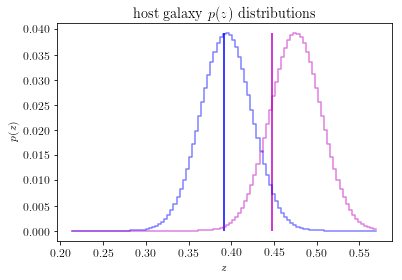

In [29]:
for s in range(n_sne)[:len(colors)-1]:
    plt.step(z_bins[1:], pzs[s], color=colors[s], alpha=0.5)
    plt.vlines(true_params[s]['z'], 0., max(pzs[s]), color=colors[s])
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z)$')
plt.title(r'host galaxy $p(z)$ distributions')
plt.savefig('plots/host_pzs.png')

**Host galaxy photometry selection function**

$\ln[p(t, z, \mu | \vec{\beta})]$

The selection function can be represented by $\ln[p(z | \vec{\beta})]$.  A selection function in which $\vec{\beta}$ is comprised of magnitude limits in all photometric bands is commonly imposed on galaxy surveys, such that $p(\vec{f} | \vec{\beta})$ is known (and often is a step function in as many dimensions as there are filters).  Furthermore, we have a reasonably good idea of what $p(z | \vec{f})$ is.  The selection function we want is just $\int\ p(z | \vec{f})\ p(\vec{f} | \vec{\beta})\ d\vec{f}$.  

In [30]:
# We emulate this using data from a realistic galaxy simulation.
# We want the number of galaxies as a function of redshift, SED type, and luminosity.
# (Buzzard, for example, includes this.)
# Using a realistic set of magnitude limits, we want to calculate the recovered fraction
# of galaxies as a function of redshift, SED type, and luminosity.
# Then we just integrate over SED type and luminosity to get $p(z | \vec{\beta})$

# pz_selfun = np.ones(n_zs-1)
# pz_selfun /= np.sum(pz_selfun * z_difs)
# assert np.isclose(np.sum(pz_selfun * z_difs), 1.)
# ln_pz_selfun = safe_log(pz_selfun)

host_sel_fun = np.ones(n_zs-1)
host_sel_fun = normalize_z(host_sel_fun)
# host_sel_fun_norm = np.sum(host_sel_fun * z_difs)
# host_sel_fun /= host_sel_fun_norm
# assert np.isclose(np.sum(host_sel_fun * z_difs), 1.)
ln_host_selection_function = safe_log(host_sel_fun)

#interim_hyperparams['pz_sel_fun'] = ln_host_selection_function

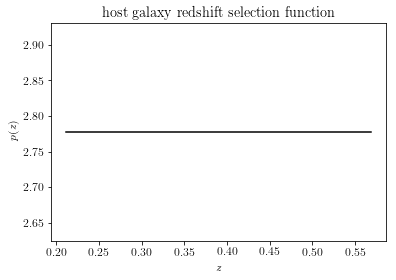

In [31]:
plt.plot(z_mids, host_sel_fun, color='k')
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z)$')
plt.title(r'host galaxy redshift selection function')
plt.savefig('plots/pz_sel_fun.png')

**Host galaxy photometry interim prior**

$\ln[p(t, z, \mu | \vec{\varphi}^{*})]$

In [32]:
# read in the SDSS DR7 one instead
# separate interim prior from LC fitter and photo-z PDFs: this is for photo-z PDFs, flat for now, replace with SDSS n(z)
pz_interim = np.ones(n_zs-1)
pz_interim = normalize_z(pz_interim)
# pz_interim /= np.sum(pz_interim * z_difs)
# assert np.isclose(np.sum(pz_interim * z_difs), 1.)
ln_pz_interim = safe_log(pz_interim)

#interim_hyperparams = {}
#interim_hyperparams['pz_int_pr'] = ln_pz_interim

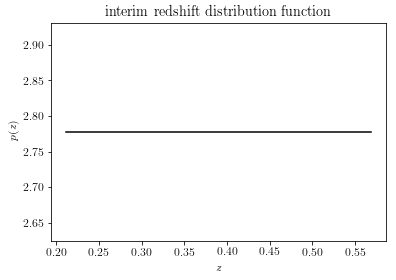

In [33]:
plt.plot(z_mids, pz_interim, color='k')
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z)$')
plt.title(r'interim redshift distribution function')
plt.savefig('plots/pz_interim_prior.png')

### Putting everything together



In [34]:
ln_host_probs = reg_vals(ln_pzs + ln_host_selection_function[np.newaxis, :] + ln_pz_interim[np.newaxis, :])
host_probs = np.exp(ln_host_probs)[:, np.newaxis, :, np.newaxis] * unity_all
host_probs = normalize_all(host_probs)
ln_host_probs = safe_log(host_probs)

In [35]:
# for s in range(n_sne):
#     for hub in host_probs[s]:
#         print(true_params[s], np.sum(hub * z_difs[:, np.newaxis] * mu_difs[np.newaxis, :]))

In [36]:
ln_sn_probs = reg_vals(sheet_cake + ln_sn_selection_function[np.newaxis, :] + ln_sn_interim[np.newaxis, :])
sn_probs = np.exp(ln_sn_probs)
sn_probs = normalize_all(sn_probs)
ln_sn_probs = safe_log(sn_probs)

In [37]:
# for s in range(n_sne):
#     for hub in sn_probs[s]:
#         print(true_params[s], np.sum(hub * z_difs[:, np.newaxis] * mu_difs[np.newaxis, :]))

In [38]:
interim_ln_posteriors = reg_vals(ln_host_probs + ln_sn_probs)
interim_posts = np.exp(interim_ln_posteriors)
interim_posts = normalize_all(interim_posts)
interim_ln_posteriors = safe_log(interim_posts)

In [39]:
# for s in range(n_sne):
#     for hub in interim_posts[s]:
#         print(true_params[s], np.sum(hub * z_difs[:, np.newaxis] * mu_difs[np.newaxis, :]))

We write this to a file for the inference notebook to read in.

In [40]:
# write true hyperparameters just to check

sn_id = ['CID_%i'%n for n in np.arange(0,n_sne,1)]

truth = {}
binned_n_of_z = np.zeros((n_types, n_zs-1))
for t in range(n_types):
    cdfs = true_n_of_z[t].cdf(z_bins)
    binned_n_of_z[t] = (cdfs[1:] - cdfs[:-1])
binned_n_of_z = frac_types[:, np.newaxis] * np.array(binned_n_of_z)# / z_range
binned_n_of_z /= np.sum(binned_n_of_z * z_difs[np.newaxis, :])
assert np.isclose(np.sum(binned_n_of_z * z_difs[np.newaxis, :]), 1.)
truth['phi'] = binned_n_of_z
truth['theta'] = true_hyperparams
truth['data'] = true_params
truth['id']=sn_id 
                     
with open('data/truth.hkl', 'w') as true_file:
    hickle.dump(truth, true_file)

# write axes (types, z_bins, mu_bins)
# write interim prior (interim_ln_prior)
# write interim posteriors (ln_interim_posteriors)



output = {'types': types, 'z_bins': z_bins, 'mu_bins': mu_bins}
output['ln host selection function'] = ln_host_selection_function
output['host interim ln prior'] = ln_pz_interim
output['ln sn selection function'] = ln_sn_selection_function
output['sn interim ln prior'] = ln_sn_interim
output['ln selection function'] = safe_log(normalize_one(np.exp(reg_vals(output['ln host selection function'][np.newaxis, :, np.newaxis] + output['ln sn selection function']))))
output['interim ln prior'] = safe_log(normalize_one(np.exp(reg_vals(output['host interim ln prior'][np.newaxis, :, np.newaxis] + output['sn interim ln prior']))))
output['ln prior info'] = safe_log(normalize_one(np.exp(reg_vals(output['interim ln prior'] + output['ln selection function']))))
output['interim ln posteriors'] = interim_ln_posteriors
output['id'] = sn_id

with open('data/data.hkl', 'w') as out_file:
    hickle.dump(output, out_file)
    
    
true_id=truth['id']
true_zs = [true_param['z'] for true_param in true_params]
true_mus = [true_param['mu'] for true_param in true_params]

#for s in range(n_sne):
#    print(true_id[s], true_zs[s], true_mus[s], sn_id[s], z_bins[s], mu_bins[s])

Let's see what these final results look like!

CID_2 0.588217615833 42.7878526641858 CID_2 0.2172 40.0947174214
CID_26 0.346173926764 41.40755837024433 CID_26 0.3036 40.7671330212
CID_0 0.391424367681 41.72266831254245 CID_0 0.21 40.0386827881


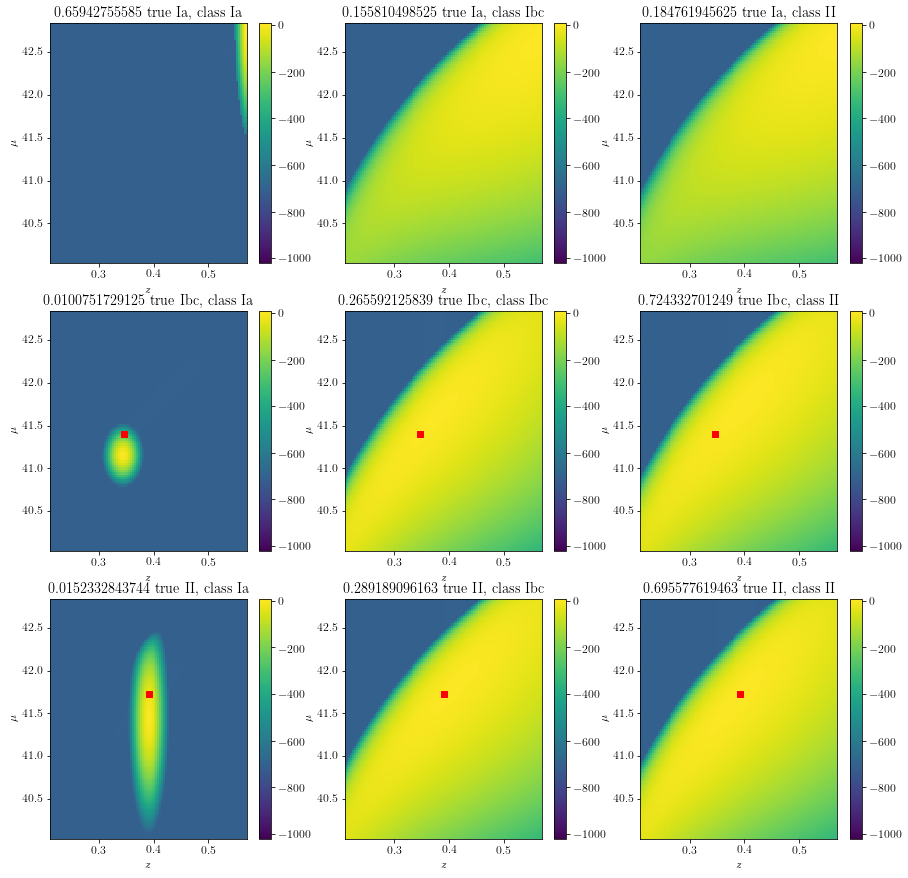

In [41]:
# these are going to get a lot narrower
fig = plt.figure(figsize=(n_types*5, n_types*5))
p = 0
for s in posters:
    print(true_id[s], true_zs[s], true_mus[s], sn_id[s], z_bins[s], mu_bins[s])
    type_dist = np.sum(np.sum(np.exp(interim_ln_posteriors[s]) * mu_difs[np.newaxis, np.newaxis, :] * z_difs[np.newaxis, :, np.newaxis], axis=2), axis=1)
    for t in range(n_types):
        p += 1
        plt.subplot(n_types, n_types, p)
        plt.pcolormesh(z_bins, mu_bins, interim_ln_posteriors[s][t].T, cmap='viridis', vmin = pmin, vmax = pmax)
        plt.colorbar()
        plt.scatter(true_params[s]['z'], true_params[s]['mu'], color='k', marker='o')
        plt.scatter(true_zs[s], true_mus[s], color='r', marker='s')
        plt.title(str(type_dist[t])+' true '+true_params[s]['t']+', class '+types[t])
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
plt.savefig('plots/out_interim_posteriors.png')

# Ignore everything after this!

We plot the combined likelihoods for when lightcurves and host galaxy photometry are available.  For the same supernovae as in the previous plot, you can see how the constraints in $z$ become much narrower when the redshift likelihoods are included.

## Making interim posteriors

The likelihoods we just constructed are all well and good, and they really do exist in nature.  However, they are not things we observers are in general able to obtain.  To use them in inference, we would need to regularly integrate over the entire space of data, which is rarely something we know how to do.  When we run a code that produces the probability distribution of unobservable parameters, it really calculates a posterior, not a likelihood; because its inputs are data, it must be conditioning its estimate on that information.  

In addition to that, any way of estimating our unobservable parameters from data also conditions their posteriors on other information, namely interim priors and selection functions.  In reality, when we perform classification, lightcurve fitting, and photo-$z$ PDF estimation, we are finding interim posteriors $p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{f}_{n}, \underline{\xi}, \vec{\alpha}, \vec{\beta})$ instead of likelihoods $p(\underline{\ell}_{n}, \vec{f}_{n} | t_{n}, z_{n}, \mu_{n})$, due to the assumptions about the distributions of our latent variables and the propagation of selection effects on the data.  In our case, choices of the interim hyperpriors $\underline{\xi}$ will translate directly into a prior belief about the `3D` distribution $p(t, z, \mu | \underline{\xi}, \vec{\alpha}, \vec{\beta})$ that is independent of any observations (and thus independent of $n$).

We must now define a function that produces the posterior probability of a supernova taking the value of a particular pair $(z, \mu)$ under a given set of cosmological parameters $\vec{\Omega}$.

Using this function, we can construct an interim prior probability, which has the dimensions of a single `3D` probability distribution.

In [42]:
# # note the approximation of cdf[z_min, z_max] = pdf[z_mid]
# interim_sheet = np.zeros((n_zs-1, n_mus-1))
# for z in range(n_zs-1):
#     for mu in range(n_mus-1):
#         ln_prob = inverter(z_mids[z], mu_mids[mu])
#         interim_sheet[z][mu] = ln_prob
# interim_ln_prior = reg_vals(interim_ln_n_of_z[:, np.newaxis] + interim_sheet[np.newaxis, :])
# interim_prior = np.exp(interim_ln_prior)
# interim_prior /= np.sum(interim_prior * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
# interim_ln_prior = safe_log(interim_prior)
# assert np.isclose(np.sum(interim_prior * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :]), 1.)

We plot the log of the combined interim prior and show that it is reasonable but not too restrictive.

### Selection Functions

We have not yet included selection effects in this treatment.  The graphical model included known hyperparameters $\vec{\alpha}$ and $\vec{\beta}$ to represent the selection function for supernova lightcurves and host galaxy photometry.  If these hyperparameters are known, then we can safely say we know $p(\underline{\ell}_{n} | \vec{\alpha})$ and $p(\vec{f}_{n} | \vec{\beta})$ for all supernovae $n$ in our catalog.  However, what we really need is $p(t_{n}, z_{n}, \mu_{n} | \vec{\alpha}, \vec{\beta})$.  We obtain these using an approach similar to <a href="https://github.com/ixkael/Photoz-tools/blob/master/Photoz%20galaxy%20survey%20mock%20and%20N(z)%20inference.ipynb">that of Boris Leistedt</a>.  *Actually, I'm not really sure how to relate what we're doing, which we discussed with Boris, to what's in his notebook.*

We wrap up the simulation/emulation of the selection functions by combining the terms as follows: $\ln[p(t, z, \mu | \vec{\alpha}, \vec{\beta})] = \ln[p(t, z, \mu | \vec{\alpha})] + \ln[p(z | \vec{\beta})]$